In [1]:
import subprocess
packages = ["pennylane", "networkx", "pennylane-qulacs", "qulacs"]
for package in packages:
    subprocess.run(["pip", "install", package])
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import torch
from scipy.linalg import expm
from itertools import combinations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 27.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 14.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.4/944.4 kB 16.8 MB/s eta 0:00:0000:01



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


Cost Hamiltonian 0.5 * (Z(0) @ Z(1)) + 0.5 * (Z(0) @ Z(3)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(2) @ Z(3)) + -0.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ I(3)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(2) @ I(3))
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


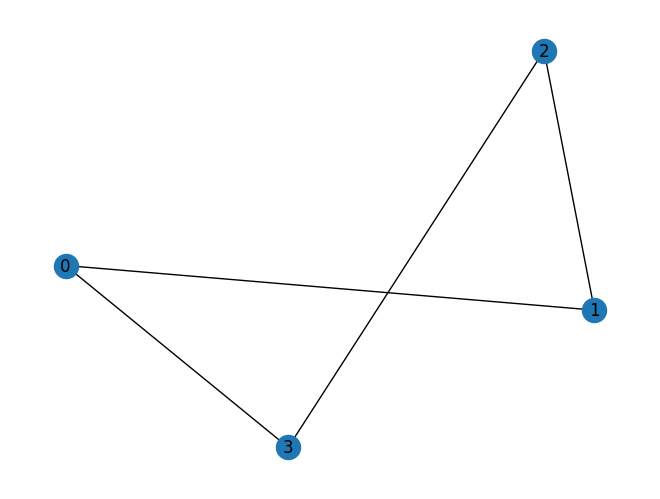

In [3]:
# @title QAOA
#Hamiltonian Maxcut
n = 4 #Nodes
n_qubits=n
wires=range(n_qubits)
edges = [(i, (i+1)%n) for i in range(n)]

weights = [1] * n


#Graph
graph=nx.Graph(edges)

nx.draw(graph,with_labels=True)

#QAOA cost and mixer hamiltonian using maxcut as baseline
cost_h, mixer_h = qaoa.cost.maxcut(graph)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

In [4]:
# @title Circuit
#variational circuit
def qaoa_layer(gamma, alpha):
  qaoa.cost_layer(gamma, cost_h)
  qaoa.mixer_layer(alpha, mixer_h)

depth = 4

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[:,0], params[:,1])

def cost_function(params):
  circuit(params)

qaoa_dev = qml.device("qulacs.simulator", wires=wires)
#The alt_cost function is the expectation value of cost_h which we want to minimize.
@qml.qnode(qaoa_dev)
def alt_cost(params):
  cost_function(params)
  return qml.expval(cost_h)

@qml.qnode(qaoa_dev)
def alt_probs(params):
  cost_function(params)
  return qml.probs()

In [5]:
# @title backward? training

optimizer = qml.GradientDescentOptimizer(0.01)
steps = 100
params = np.array(np.random.uniform(0, 2*np.pi, size=(depth, 2)),requires_grad=True)

# optimize parameters
def optimize_params_b(params, steps):
  params = params.copy()
  for i in range(steps):
    params = optimizer.step(alt_cost, params)
  return params

# Each layer's parameters are optimized based on the previous layer's improved values.
for j in range(0,depth):
  #initparams to optimize the next layer
  # Update the next layer with the optimized parameters from the init layer
  if j==0:
    params[j] = optimize_params_b(params, steps)[j]
    print(f"opt{j}", params, "\n")
  elif j!=0 and j < depth+1 :
    params[j]=params[j-1]
    params[j] = optimize_params_b(params, steps)[j]/2
    print(f"opt{j}", params, "\n")
#  print("param each", optimized_params[j-1], '\n\n')

print("params:\n", params)

opt0 [[3.47720778 2.88561347]
 [1.4448908  0.43735581]
 [4.17579387 0.15172287]
 [1.31991792 5.96926165]] 



In [ ]:
print("Optimal Parameters")
print(params)
print("Cost\n",alt_cost(params))
print("probs\n",alt_probs(params))
plt.bar(range(2**n_qubits),alt_probs(params).flatten())
plt.show()